In [1]:
# Import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


    
"""결측값 처리"""

class MissingValueHandler:
    def __init__(self, dataframe):
        self.df = dataframe

    def fill_missing(self, column_name, method):
        column_data = self.df[column_name]  # 컬럼 데이터 가져오기
        
        if method == 'mean':
            return self.df[column_name].fillna(self.df[column_name].mean())
        elif method == 'median':
            return self.df[column_name].fillna(self.df[column_name].median())
        elif method == 'mode':
            return self.df[column_name].fillna(self.df[column_name].mode()[0])
        elif method == 'zero':
            return self.df[column_name].fillna(0)
        else:
            raise ValueError("지원하지 않는 방법입니다. 'mean', 'median', 'mode', 또는 'zero' 중에서 선택하세요.")

    def drop(self):
        self.df = self.df.dropna()  # 결측값 있는 행을 삭제
        return self.df

    def drop_loc(self):
        self.df = self.df.dropna(axis=1)  # 결측값 있는 열을 삭제
        return self.df

    def get_dataframe(self):
        return self.df  # 현재의 데이터프레임 반환



"""범주형 변수 인코딩" 또는 "레이블 인코딩"""

class CategoricalEncoder:
    def __init__(self, dataframe):
        from sklearn.preprocessing import LabelEncoder
        self.df = dataframe
        self.encoder = LabelEncoder()  # LabelEncoder 객체 생성

    def encode_labels(self):
        categorical_cols = self.df.select_dtypes(include=['object']).columns  # 범주형 열 선택

        for col in categorical_cols:
            self.df.loc[:, col] = self.encoder.fit_transform(self.df[col])  # .loc를 사용하여 열을 수정

        return self.df


"""스케일링""" 

def scale_data(df_encoded, method='StandardScaler'):
    # 예외 처리: 'StandardScaler' 또는 'MinMaxScaler' 외의 값이면 오류 발생
    if method == 'StandardScaler':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    elif method == 'MinMaxScaler':
        from sklearn.preprocessing import MinMaxScale
        scaler = MinMaxScaler()
    else:
        raise ValueError("method 파라미터는 'StandardScaler' 또는 'MinMaxScaler'이어야 합니다.")
    
    # 스케일링을 적용할 컬럼을 찾기
    columns_to_scale = []
    for col in df_encoded.columns:
        # 각 컬럼이 0과 1만 포함하는 경우는 스케일링하지 않음
        if not df_encoded[col].isin([0, 1]).all():
            columns_to_scale.append(col)
    
    # 스케일링할 컬럼만 따로 추출
    df_to_scale = df_encoded[columns_to_scale]
    
    # 해당 컬럼만 스케일링
    if not df_to_scale.empty:
        df_scaled = scaler.fit_transform(df_to_scale)
        df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale)
        
        # .loc을 사용하여 원본 DataFrame에 값을 안전하게 할당
        df_encoded.loc[:, columns_to_scale] = df_scaled
    
    return df_encoded



"""이상치 탐지 함수"""

def detect_outliers(ys, method='outliers_iqr'):
    if method == 'outliers_iqr':
        # IQR 방법
        quartile_1, quartile_3 = np.percentile(ys, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return np.where((ys > upper_bound) | (ys < lower_bound))
    
    elif method == 'outliers_z_score':
        # Z-Score 방법
        threshold = 3
        mean_y = np.mean(ys)
        stdev_y = np.std(ys)
        z_scores = [(y - mean_y) / stdev_y for y in ys]
        return np.where(np.abs(z_scores) > threshold)
    
    elif method == 'outliers_modified_z_score':
        # Modified Z-Score 방법
        threshold = 3.5
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                             for y in ys]
        return np.where(np.abs(modified_z_scores) > threshold)
    
    else:
        raise ValueError("잘못된 방법입니다. ['outliers_iqr', 'outliers_z_score', 'outliers_modified_z_score'] 중 하나를 선택해주세요.")


        
"""X. y 분리"""
def split_features_and_target(encoded_df, target_column):
    
    X = encoded_df.drop(columns=[target_column])  # 타겟 열 제외
    y_labels = encoded_df[target_column]  # 타겟 열 선택
    return X, y_labels


# 1. 데이터 전처리
#X = dataset.iloc[:, :-1].values  # 특성
#labels = dataset.iloc[:, -1].values  # 레이블



"""모델 선택"""
class MI:  # ModelInitializer
    def __init__(self, model_type='naive_bayes', **kwargs):
        self.model = self.initialize_model(model_type, **kwargs)
        if X_train is not None and y_train is not None:
            self.fit_model(X_train, y_train)

    def initialize_model(self, model_type, **kwargs):
        """모델 초기화 함수."""
        if model_type == 'GaussianNB':
            from sklearn.naive_bayes import GaussianNB
            model = GaussianNB(**kwargs)  # 지도 분류 / 큰 데이터셋에 적합, 노이즈 데이터 셋 가능
            print("Initialized GaussianNB model (suitable for larger datasets with noise).")
        elif model_type == 'SVM':
            from sklearn.svm import SVC
            model = SVC(**kwargs)  # 지도 분류 / 적은 데이터 적합, 노이즈가 많은 데이터 적은 셋 적합.
        elif model_type == 'DecisionTreeClassifier':
            from sklearn.tree import DecisionTreeClassifier
            model = DecisionTreeClassifier(**kwargs)  # 지도 분류 / 의사 결정 나무
        elif model_type == 'RandomForestRegressor':
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(**kwargs)  # 지도 분류 / 랜덤포레스트
        elif model_type == 'PCA':
            from sklearn.decomposition import PCA
            model = PCA(**kwargs)  # PCA 부분작동
        elif model_type == 'KNeighborsClassifier':
            from sklearn.neighbors import KNeighborsClassifier
            model = KNeighborsClassifier(**kwargs)  # KNN
        elif model_type == 'AgglomerativeClustering':
            from sklearn.cluster import AgglomerativeClustering
            model = AgglomerativeClustering(**kwargs)  # AgglomerativeClustering
        elif model_type == 'DBSCAN':
            from sklearn.cluster import DBSCAN
            model = DBSCAN(**kwargs)  # DBSCAN            
        else:
            raise ValueError("Invalid model type. Choose 'naive_bayes' or 'SVM'.")


        return model
    def fit_model(self, X_train_scaled, y_train_scaled):
        """모델을 학습합니다."""
        self.model.fit(X_train_scaled, y_train_scaled)
        print(f"[{self.model.__class__.__name__}] Model has been fitted.")
        
    def get_model(self):
        """초기화된 모델을 반환합니다."""
        return self.model



In [2]:
# 데이터셋 로드
df = sns.load_dataset('titanic')
df_filter = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

# 결측값 확인
df_filter_check_missing = MissingValueHandler(df_filter)

#MVS.summarize(preprocessing=False)  # Before 상태
print("--- Describe of dtypes column ---")
print(df_filter.describe())
print("--- Sum of dtypes column ---")
print(df_filter_check_missing.df.dtypes)
print("--- Before Fill Missing ---")
print(df_filter_check_missing.df.isnull().sum())

--- Describe of dtypes column ---
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
--- Sum of dtypes column ---
survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object
--- Before Fill Missing ---
survived      0
pclass        0
s

In [3]:
# 결측값 처리
MVS = MissingValueHandler(df_filter)
df_filter.loc[:, 'age'] = MVS.fill_missing('age', method='mean')
df_filter.loc[:, 'embarked'] = MVS.fill_missing('embarked', method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')

#df_filter = MVS.drop()
#df_filter = MVS.drop_loc()

print("--- After Fill Missing ---")
print(df_filter.isnull().sum())

--- After Fill Missing ---
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [4]:
#라벨링
encoder = CategoricalEncoder(df_filter)
df_encoded = encoder.encode_labels()

print(df_encoded)

# 스케일화
df_scaled = scale_data(df_encoded, method='StandardScaler')
#df_scaled = scale_data(df_encoded, method='MinMaxScaler')

print(df_scaled)

     survived  pclass sex        age  sibsp  parch     fare embarked
0           0       3   1  22.000000      1      0   7.2500        2
1           1       1   0  38.000000      1      0  71.2833        0
2           1       3   0  26.000000      0      0   7.9250        2
3           1       1   0  35.000000      1      0  53.1000        2
4           0       3   1  35.000000      0      0   8.0500        2
..        ...     ...  ..        ...    ...    ...      ...      ...
886         0       2   1  27.000000      0      0  13.0000        2
887         1       1   0  19.000000      0      0  30.0000        2
888         0       3   0  29.699118      1      2  23.4500        2
889         1       1   1  26.000000      0      0  30.0000        0
890         0       3   1  32.000000      0      0   7.7500        1

[891 rows x 8 columns]
     survived    pclass sex       age     sibsp     parch      fare  embarked
0           0  0.827377   1 -0.592481  0.432793 -0.473674 -0.502445  0

Initial number of rows before outlier removal: 891
Outlier values in the 'survived' column: Series([], Name: survived, dtype: int64)
Number of outliers detected in the 'survived' column: 0
Outlier values in the 'pclass' column: Series([], Name: pclass, dtype: float64)
Number of outliers detected in the 'pclass' column: 0
Outlier values in the 'age' column: 7     -2.131568
11     2.177876
15     1.947013
16    -2.131568
33     2.793511
         ...   
827   -2.208522
829    2.485693
831   -2.221604
851    3.409146
879    2.023967
Name: age, Length: 66, dtype: float64
Number of outliers detected in the 'age' column: 66
Outlier values in the 'sibsp' column: 24     2.247470
27     2.247470
50     3.154809
59     4.062148
63     2.247470
68     3.154809
71     4.062148
85     2.247470
88     2.247470
159    6.784163
171    3.154809
176    2.247470
180    6.784163
182    3.154809
201    6.784163
229    2.247470
233    3.154809
261    3.154809
266    3.154809
278    3.154809
324    6.784163
3

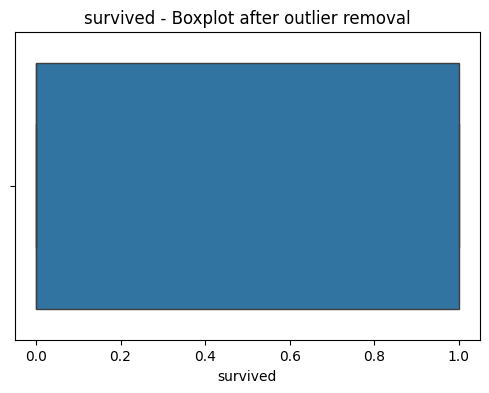

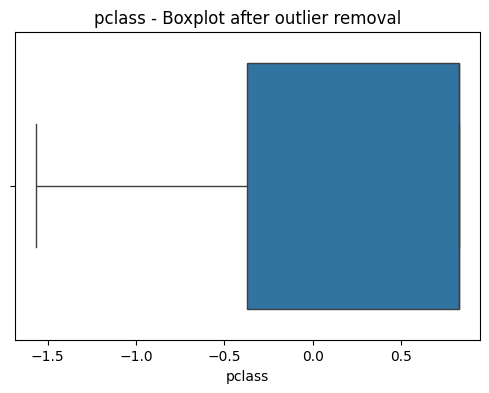

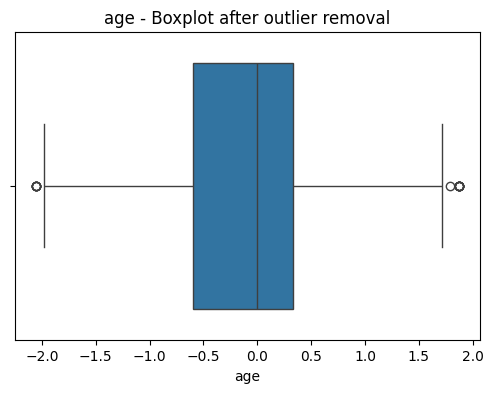

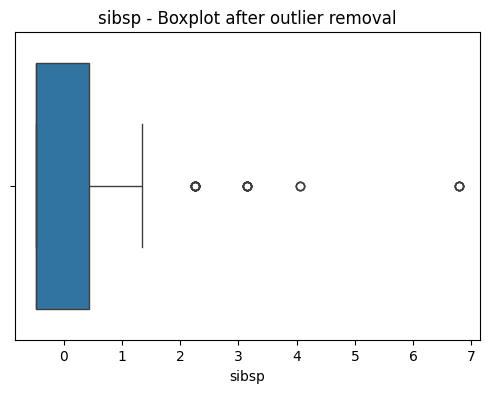

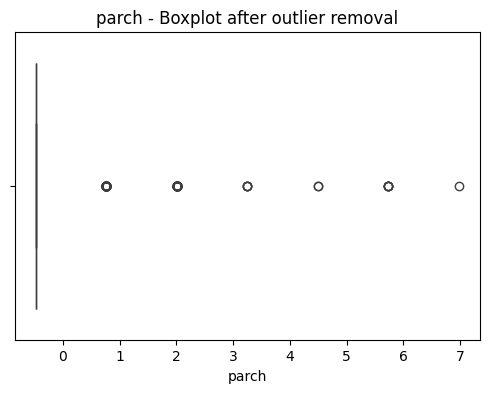

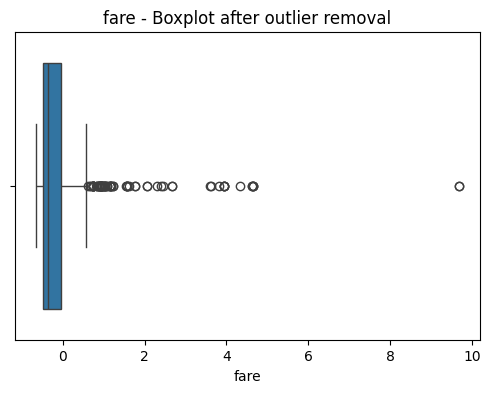


Comparison of row counts before and after outlier removal: 891 -> 581


In [5]:
import matplotlib.pyplot as plt
# IQR 기반 이상치 탐지 함수
outliers_model = 'outliers_iqr'
#outliers_model = 'outliers_z_score'
#outliers_model = 'outliers_modified_z_score' 

# 이상치 제거 전 데이터프레임의 행 수 저장
initial_row_count = df_scaled.shape[0]
print(f"Initial number of rows before outlier removal: {initial_row_count}")

# df_scaled는 이미 스케일링된 데이터프레임입니다
for column in df_scaled.columns:
    if df_scaled[column].dtype in ['int64', 'float64']:  # 숫자형 컬럼만 처리
        # 선택한 모델로 이상치 탐지
        outliers = detect_outliers(df_scaled[column], method=outliers_model)
        
        # 이상치 값 출력
        outlier_values = df_scaled[column].iloc[outliers[0]]
        print(f"Outlier values in the '{column}' column:", outlier_values)
        
        # 이상치 개수 출력
        print(f"Number of outliers detected in the '{column}' column:", len(outliers[0]))

        # 이상치 제거 (이상치가 있는 행을 제거)
        if len(outliers[0]) > 0:  # 이상치가 있을 때만 제거
            valid_outliers = [idx for idx in outliers[0] if idx in df_scaled.index]
            if valid_outliers:  # 유효한 이상치 인덱스만 제거
                df_scaled = df_scaled.drop(valid_outliers)

# 이상치 제거 후 데이터프레임의 행 수
final_row_count = df_scaled.shape[0]
print(f"Final number of rows after outlier removal: {final_row_count}")

# 이상치 제거 후 데이터프레임 출력
print("\nDataframe after outlier removal:")
print(df_scaled)

# 이상치 제거 후 각 컬럼에 대해 박스플롯 시각화
for column in df_scaled.columns:
    if df_scaled[column].dtype in ['int64', 'float64']:  # 숫자형 컬럼만 처리
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df_scaled[column])
        plt.title(f'{column} - Boxplot after outlier removal')
        plt.show()

# 이상치 제거 전후 행 개수 비교 출력
print(f"\nComparison of row counts before and after outlier removal: {initial_row_count} -> {final_row_count}")